# AI in Finance: Seminar IV.

## Initialization

In [1]:
# imports:

## basic libraries:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import math
import matplotlib
## modelling:
import statsmodels.formula.api as smf

##
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

In [2]:
# data
ocr = pd.read_csv("../data/ocr.csv").drop("Unnamed: 0", axis=1)  # the ocr is our train set
oct = pd.read_csv("../data/oct.csv").drop("Unnamed: 0", axis=1)  # the oct is the test set

In [3]:
# settings
matplotlib.rcParams['figure.figsize'] = (20, 10)


In [4]:
ocr.describe()

,price,km,age,km10,power_lowest,power_low,power_mid,power_high,power_highest,ba,...,za,diesel,petrol,petgas,man,eng1,eng2,eng3,eng4,eng6
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.0000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,13696.583333,172.708687,6.605556,0.011111,0.029167,0.204167,0.230556,0.368056,0.159722,0.233333,...,0.120833,0.880556,0.1125,0.006944,0.500000,0.126389,0.069444,0.212500,0.063889,0.263889
std,5786.612018,70.462335,3.675650,0.104895,0.168390,0.403372,0.421481,0.482612,0.366603,0.423247,...,0.326160,0.324536,0.3162,0.083101,0.500348,0.332518,0.254385,0.409361,0.244725,0.441046
min,1400.000000,0.006000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9490.000000,132.953250,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13990.000000,171.677500,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.0000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16900.000000,210.001750,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.0000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,34900.000000,500.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1 OLS Models

At this point, we write down formulas that specify all of our models. These are nested in a dictionary for easier manipulation
I use the formula-based Statsmodels API syntax

### 1.1 Models Fitting

In [5]:
model_formulas = {
    "m1": "price ~ km",
    "m2": "price ~ age",
    "m3": "price ~ km + age",
    "m4": "price ~ km + age + km10 + power_lowest + power_low + power_mid + power_high + "
          "power_highest + ba + bb + ke + nr + po + tn + tt + petrol + petgas + man + eng1 + "
          "eng2 + eng3 + eng4 + eng6",
    "m5": "price ~ km + I(km**2) + age + I(age**2) + diesel + man + eng1 + eng2 + eng3 + eng4 + eng6"
}

The following function iterates over all models and returns the fitted objects

In [6]:
def fit_ols_models(models_specs: dict, data: pd.DataFrame) -> dict:
    """
    Purpose: For the specified formulas, fit the OLS model and return all its attributes
    """

    models_fitted = {}
    for model, formula in models_specs.items():
        models_fitted[model] = smf.ols(formula=formula, data=data).fit()

    return models_fitted

In [7]:
models_res = fit_ols_models(model_formulas, ocr)  # object containing all fitted models

The following function iterates over all of our fitted models and prints summary tables with all respective summary tables

In [8]:
def print_models_summary(models_res_list: dict) -> None:
    """
    Purpose: Print summary tables for each model from the dictionary of fitted models
    """

    for mod, res in models_res_list.items():
        print(f"{mod}:\n\n "
              f"Coefficients: \n"
              f"{res.summary()} \n\n")

In [9]:
print_models_summary(models_res)

m1:

 Coefficients: 
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     877.3
Date:                Fri, 21 Oct 2022   Prob (F-statistic):          1.34e-126
Time:                        12:48:09   Log-Likelihood:                -6971.3
No. Observations:                 720   AIC:                         1.395e+04
Df Residuals:                     718   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.421e+04    383.48

### 1.2 Models Evaluation

Now that we've fitted the model, it's time to evaluate our results. First we generate predicitons based on our models.

In [10]:
def generate_predictions(models_fitted: dict, data_test: pd.DataFrame) -> dict:
    """
    Purpose: For all fitted models, generate predictions for the test set and store them in a dictionary
    """
    pred_vals = {}
    for model, specs in models_fitted.items():
        pred_vals[model] = specs.predict(data_test)

    return pred_vals

In [11]:
oct_pred = generate_predictions(models_res, oct)

We can plot the actual values in our test set against the predictions. This has the same effect as the residual analysis.
We can therefore check if the predicitons substantially differ for different values of our target variable

In [12]:
from sklearn.metrics import mean_squared_error as mse
def compare_models_metrics(preds_dict, data_observed, metric, print_res=False):

    metric_dict = {}

    for mod, fit in preds_dict.items():
        metric_dict[mod] = metric(preds_dict[mod], data_observed)
        # metric_dict[mod] = mse(data_observed, preds_dict[mod])

    if print_res:
        for key, val in sorted(metric_dict.items(), key = lambda x: x[1], reverse=False) :
            print(f"Model {key} had the metric score of of: {val}\n")

    return metric_dict

In [13]:
mse_dta = compare_models_metrics(oct_pred, oct[['price']], mse, True)

Model m5 had the metric score of of: 3376994.6205653464

Model m4 had the metric score of of: 4643638.637697083

Model m3 had the metric score of of: 7082020.164427458

Model m2 had the metric score of of: 11002840.766314

Model m1 had the metric score of of: 13486177.111468993



In [14]:
def get_grid_shape(data):
    """
    Purpose: Helper function to create a tupe which would determine the subplots shape
    """
    grid_size = (math.ceil(np.sqrt(len(data))), math.floor(np.sqrt(len(data))))

    return grid_size

In [15]:
def actual_vs_fit_plot(fitted, actuals, mse):
    """
    Purpose: Generate scatter plots to plot the actual values against the fitted ones
    """
    shape = get_grid_shape(fitted)

    fig, axs = plt.subplots(shape[0], shape[1], figsize=tuple([5*x for x in shape]))
    fig.suptitle("Actual vs. Fitted values Regression Plot")
    i = 0
    j = 0
    for model, vals in fitted.items():
        sns.regplot(ax=axs[i, j % 2], x=vals, y=actuals, line_kws={'color': 'red'})
        axs[i, j % 2].set_title(f"{model}: MSE of {round(mse[model])}")
        i = i + j
        j = (j + 1) % 2

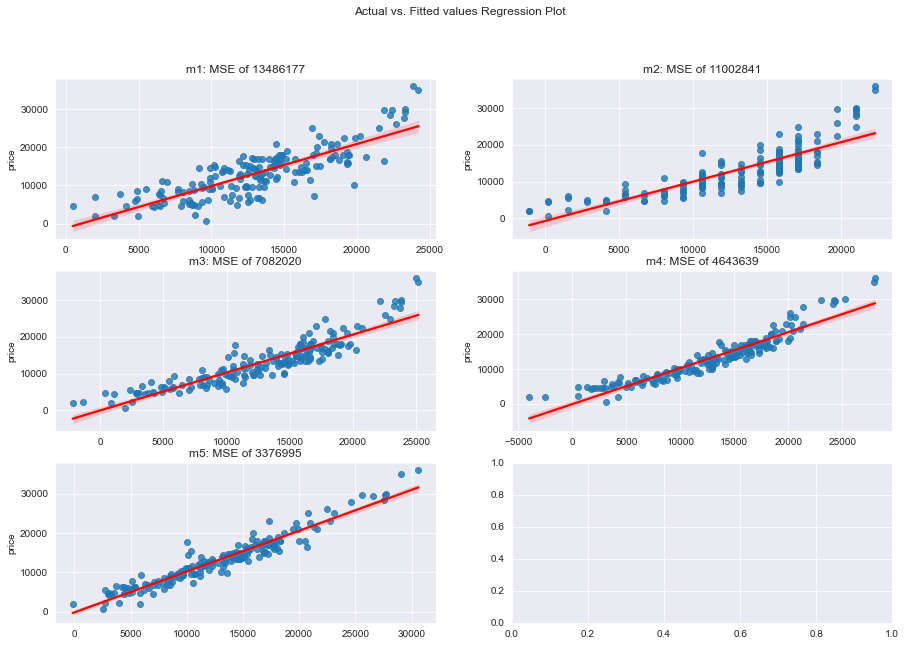

In [16]:
actual_vs_fit_plot(oct_pred, oct[['price']], mse_dta)

## 2 Bootstraping

At first, I initialize the functionction which is meant to extract the coefficients of our regression

In [17]:
def est_model(data, formula):
    # bootstrap() makes an array, not a DataFrame
    estimate = smf.ols(formula, data).fit()
    coefs = estimate.params

    return coefs

In [18]:
def get_bootstrap_coefs(data, n_rep, formula):
    res = []

    for i in range(n_rep):
        smpl = data.sample(frac=1, replace=True)
        model = smf.ols(formula, smpl).fit()
        coefs = model.params

        res.append(coefs)

    return pd.DataFrame(res, columns=coefs.index)


In [19]:
bs_c = get_bootstrap_coefs(ocr, 1000, model_formulas['m4'])


In [20]:
def get_stats(data, q_list=[0.015, 0.5, 0.985]):

    stats_dict = {
        'mean': data.mean(),
        'std': data.std(),
        'se': data.std()/np.sqrt(data.shape[0]),
        'quantiles': data.quantile(q_list).set_index(pd.Index([q for q in q_list])).transpose(),
        'p_val': data.apply(lambda x: stats.ttest_1samp(x, 0)[1]),
        't_stat': data.apply(lambda x: stats.ttest_1samp(x, 0)[1])
    }

    return stats_dict




In [21]:
get_stats(bs_c)['quantiles']

,0.015,0.500,0.985
Intercept,21170.631959,23272.101091,25215.165335
km,-31.921711,-27.371790,-22.744218
age,-1035.456637,-924.464965,-814.631693
km10,-2980.019274,2900.636127,8215.901550
power_lowest,-1069.528557,498.634667,2416.549219
power_low,-3111.190213,-1602.566723,763.610908
power_mid,-1458.851110,-160.796205,1130.428443
power_high,1681.149123,3315.502934,4998.345515
power_highest,3159.621663,4680.547848,6347.877256
ba,-692.133968,54.085022,716.092977


In [22]:
get_stats(bs_c)['se']

Intercept        29.349980
km                0.066470
age               1.674298
km10             78.207083
power_lowest     26.064369
power_low        27.002621
power_mid        19.460490
power_high       24.434046
power_highest    22.623172
ba               10.392849
bb               10.459664
ke                8.775139
nr                9.592762
po               10.471379
tn               12.259149
tt               10.700342
petrol           17.906786
petgas           44.957740
man               5.405467
eng1             31.091575
eng2             30.879746
eng3             20.962084
eng4             29.159960
eng6             28.394120
dtype: float64

In [23]:
get_stats(bs_c)['mean']/get_stats(bs_c)['se']

Intercept        791.469474
km              -410.885225
age             -552.313754
km10              36.460941
power_lowest      19.585037
power_low        -57.085510
power_mid         -8.513149
power_high       136.763487
power_highest    207.482610
ba                 4.324523
bb               -67.890597
ke               -29.880059
nr               -59.742511
po                 3.467670
tn               -28.373413
tt               -44.173006
petrol            -4.287116
petgas            16.683705
man             -157.912858
eng1              85.483275
eng2              36.993963
eng3              23.981916
eng4             -27.716334
eng6             -22.449740
dtype: float64

### 2.2 Backward Elimination

In this section, I create functions that are analogous to the functions created in R by prof. Lyocsa.

In [24]:
import re

In [25]:
def extract_variables(formula):
    """
    Purpose: Extract all relevant features from the relevant formula
    """
    vars = re.findall(r'[^\s,+, ~]*', formula)
    vars = [var for var in vars if var != ""]

    return vars

In [26]:
def extract_features(formula_models_dict = model_formulas):
    features_dict = {}

    for model, formula in formula_models_dict.items():
        features_dict[model] = extract_variables(formula)
        features_dict[model] = features_dict[model][1:]

    return features_dict


### 2.2 MCS

In this part, I examine our models using the Model Confidence Set. The class I use is taken from the [M. Gong's implementation](https://michael-gong.com/blogs/model-confidence-set/) of the algorithm.

In [27]:
from AI.util.MCS import ModelConfidenceSet as MCS

In [28]:
mcs_oct = MCS((pd.DataFrame(oct_pred)
              .apply(lambda x: np.abs(x - oct['price']))), 0.01, 3, 1000).run()

In [29]:
mcs_oct.pvalues

m1    0.0
m2    0.0
m3    0.0
m4    0.0
m5    1.0
dtype: float64

### 2.3 Regularized Regression

In this section, we will use the sklearn methods instead of statsmodels as they're implemented in their Cross-Validation form

In [30]:
from sklearn import linear_model as sklm

In [31]:
lasso_reg = sklm.LassoCV(cv=10).fit(y=ocr['price'], X=ocr.drop('price', axis=1))
elastic_reg = sklm.ElasticNetCV(cv=10).fit(y=ocr['price'], X=ocr.drop('price', axis=1))
ridge_reg = sklm.RidgeCV(cv=10).fit(y=ocr['price'], X=ocr.drop('price', axis=1))

In [32]:
lasso_reg.coef_

array([ -31.18477082, -891.31144411,    0.        ,   -0.        ,
         -0.        ,   -0.        ,  345.43090801, 1288.42991566,
          0.        ,   -0.        ,   -0.        ,   -0.        ,
          0.        ,   -0.        ,   -0.        ,    0.        ,
         -0.        ,    0.        ,   -0.        , -232.27773755,
         -0.        ,   -0.        ,   -0.        ,    0.        ,
          0.        ])

In [33]:
mse(lasso_reg.predict(oct.drop('price', axis=1)), oct[['price']])

6012134.633177606

In [34]:
mse(elastic_reg.predict(oct.drop('price', axis=1)), oct[['price']])

13451207.345317226

In [35]:
mse(ridge_reg.predict(oct.drop('price', axis=1)), oct[['price']])

4643807.270641138

In [36]:
mse_dta

{'m1': 13486177.111468993,
 'm2': 11002840.766314,
 'm3': 7082020.164427458,
 'm4': 4643638.637697083,
 'm5': 3376994.6205653464}

In [37]:
regularized_reg_pred = {
    'lasso': lasso_reg.predict(oct.drop('price', axis=1)),
    'ridge': elastic_reg.predict(oct.drop('price', axis=1)),
    'elastic': elastic_reg.predict(oct.drop('price', axis=1))
}

In [38]:
regularized_reg_pred['lasso']

array([15898.03565968, 18734.29328833,  5530.11754313, 11707.53795133,
       11283.99031075,  7188.61118915, 14605.71924765, 23209.48844481,
        2229.79527181, -2218.97847435,  1963.32028685, -1382.50936676,
        2403.26727482,  2755.3511714 ,  1373.4614652 ,  3408.40313241,
        2786.79514362,  3527.05734408,  3004.45232237,   639.3719602 ,
        2893.93629291,  5948.24295023,  4070.28821762,  5129.92442221,
        4211.66234825,  3531.75050096,  6657.86024421,  5332.88554307,
        9620.41347172,  4735.17487491,  8098.54596171,  6028.74628496,
        5202.53040274,  5539.23517155,  7026.00030497,  3048.38278741,
        9053.14298116,  8212.00783329,  7863.41782552,  9292.97337815,
        6008.0710088 ,  7885.2733141 ,  9200.35076755,  9404.51850505,
        8707.64690529,  4142.24819501,  5441.27716683,  8937.44364015,
        8561.08351821,  6946.99096556, 10456.01912897,  7801.04828389,
        8280.25871211,  9317.59948554, 10030.90644404,  8264.81337352,
      

### 4.3

In [39]:
oct_pred

{'m1': 0      13209.234498
 1      16906.595119
 2       8015.049096
 3      10146.584101
 4      17057.568699
            ...     
 175    21844.691817
 176    22387.685134
 177    23301.200136
 178    24213.801624
 179    23825.862253
 Length: 180, dtype: float64,
 'm2': 0      17076.295246
 1      17076.295246
 2       6699.354618
 3      11887.824932
 4       7996.472196
            ...     
 175    19670.530403
 176    20967.647982
 177    20967.647982
 178    22264.765561
 179    22264.765561
 Length: 180, dtype: float64,
 'm3': 0      15876.443321
 1      17747.580583
 2       5797.584771
 3      10601.407504
 4      11305.044027
            ...     
 175    22109.176218
 176    23315.248087
 177    23777.554077
 178    25170.674949
 179    24974.349006
 Length: 180, dtype: float64,
 'm4': 0      16571.055397
 1      20182.416669
 2       5131.402021
 3      14132.364406
 4       7925.490937
            ...     
 175    23039.060519
 176    24207.206596
 177    25213.615590
 178

In [40]:
from AI.util.MCS import ModelConfidenceSet as MCS
mcs_oct = MCS((pd.DataFrame(oct_pred)
              .apply(lambda x: np.abs(x - oct['price']))), 0.01, 3, 1000).run()
mcs_oct.pvalues

m1    0.0
m2    0.0
m3    0.0
m4    0.0
m5    1.0
dtype: float64

In [41]:
extract_features(model_formulas)['m4']

['km',
 'age',
 'km10',
 'power_lowest',
 'power_low',
 'power_mid',
 'power_high',
 'power_highest',
 'ba',
 'bb',
 'ke',
 'nr',
 'po',
 'tn',
 'tt',
 'petrol',
 'petgas',
 'man',
 'eng1',
 'eng2',
 'eng3',
 'eng4',
 'eng6']